In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from fbprophet import Prophet
from datetime import datetime

## Read in oil data from csv

In [2]:
df_oil = pd.read_csv('brent_continuous.csv')

In [3]:
df_oil.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2019-05-31,66.24,66.28,64.37,64.49,-2.38,65.01,18048.0,57133.0,3600.0,NaN,100.0
1,2019-05-30,69.68,69.96,66.31,66.87,-2.58,68.13,97325.0,112444.0,6600.0,NaN,1346.0
2,2019-05-29,70.10,70.10,68.08,69.45,-0.66,68.96,138447.0,144605.0,7407.0,17.0,2604.0
3,2019-05-28,69.99,70.59,69.58,70.11,0.00,70.04,229587.0,192343.0,12.0,17.0,9265.0
4,2019-05-27,69.15,70.23,68.53,70.11,1.42,69.22,71979.0,199176.0,NaN,NaN,200.0


### Rename the columns, prophet needs the columns to be explicit

In [4]:
df_oil.rename(columns={'Date': 'ds', 'Settle': 'y'}, inplace=True)

In [5]:
df_oil.ds = pd.to_datetime(df_oil.ds, format="%Y-%m-%d")

In [6]:
df_oil.tail()

,ds,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
6680,1993-03-23,18.61,18.61,18.61,18.61,NaN,NaN,0.0,0.0,NaN,NaN,NaN
6681,1993-03-22,18.50,18.50,18.50,18.50,NaN,NaN,0.0,0.0,NaN,NaN,NaN
6682,1993-03-19,18.89,18.89,18.89,18.89,NaN,NaN,0.0,0.0,NaN,NaN,NaN
6683,1993-03-18,18.87,18.87,18.87,18.87,NaN,NaN,0.0,0.0,NaN,NaN,NaN
6684,1993-03-17,18.80,18.80,18.80,18.80,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [7]:
df_oil.describe()

,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
count,6624.000000,6624.000000,6624.000000,6624.000000,3953.000000,919.000000,6632.000000,6684.000000,3712.000000,2647.00000,3908.000000
mean,52.784565,53.453759,52.086591,52.787406,0.003838,57.636366,100256.833233,138912.333034,2113.271821,1141.90782,3693.160440
std,33.541544,33.900409,33.152659,33.553543,1.409154,12.549694,100065.736132,129797.099289,2167.257953,1198.09408,3941.138488
min,9.700000,9.950000,9.550000,9.640000,-10.390000,27.860000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,22.400000,22.715000,22.060000,22.340000,-0.720000,48.600000,22540.500000,58035.000000,917.000000,93.00000,900.000000
50%,48.250000,49.110000,47.470000,48.265000,0.050000,55.770000,52303.500000,84114.000000,1753.000000,851.00000,2638.500000
75%,74.692500,75.585000,73.680000,74.652500,0.760000,67.970000,170077.250000,190441.000000,2645.000000,1757.00000,5328.500000
max,146.300000,147.500000,144.250000,146.080000,10.150000,85.440000,745954.000000,676659.000000,25088.000000,7491.00000,41402.000000


In [154]:
df_oil.to_pickle('oil_price.pkl')

#### Create a subset for base line time series modeling

In [8]:
df_oil_subset = df_oil[df_oil['ds'] < '2018-03-01']

In [9]:
df_oil_subset.index = df_oil_subset.ds

In [10]:
df_oil_subset = df_oil_subset['y']

In [11]:
df_oil_subset.head()

ds
2018-02-28    64.73
2018-02-27    66.63
2018-02-26    67.50
2018-02-23    67.31
2018-02-22    66.39
Name: y, dtype: float64

##### Check for null values and fill forward 

In [12]:
df_oil_subset.isnull().count()

6362

In [13]:
df_oil_subset.fillna(method ='ffill', inplace = True)

/Users/robfang29/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### Create a hold out set

In [14]:
df_oil_test = df_oil[df_oil['ds'] > '2019-03-04']

In [15]:
df_oil_test.index = df_oil_test.ds

In [16]:
df_oil_test = df_oil_test['y']

In [17]:
df_oil_test.isnull().count()

63

In [18]:
df_oil_test.fillna(method ='ffill', inplace = True)

In [19]:
df_oil_test.tail()

ds
2019-03-11    66.58
2019-03-08    65.74
2019-03-07    66.30
2019-03-06    65.99
2019-03-05    65.86
Name: y, dtype: float64

#### Check for Stationarity

##### A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the TS models work on the assumption that the TS is stationary.
1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.


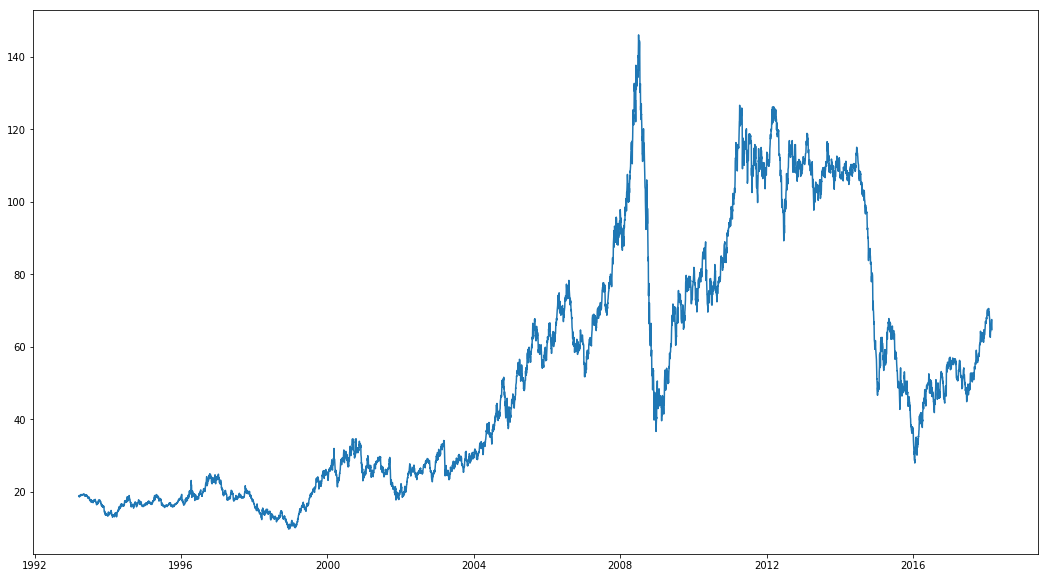

In [20]:
plt.figure(figsize=(18,10))
plt.plot(df_oil_subset)

In [21]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.resample('30D').mean()
    rolstd = timeseries.resample('30D').std()

    #Plot rolling statistics:
    plt.figure(figsize=(18,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=14)
    plt.title('Rolling Mean & Standard Deviation', fontsize=14)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

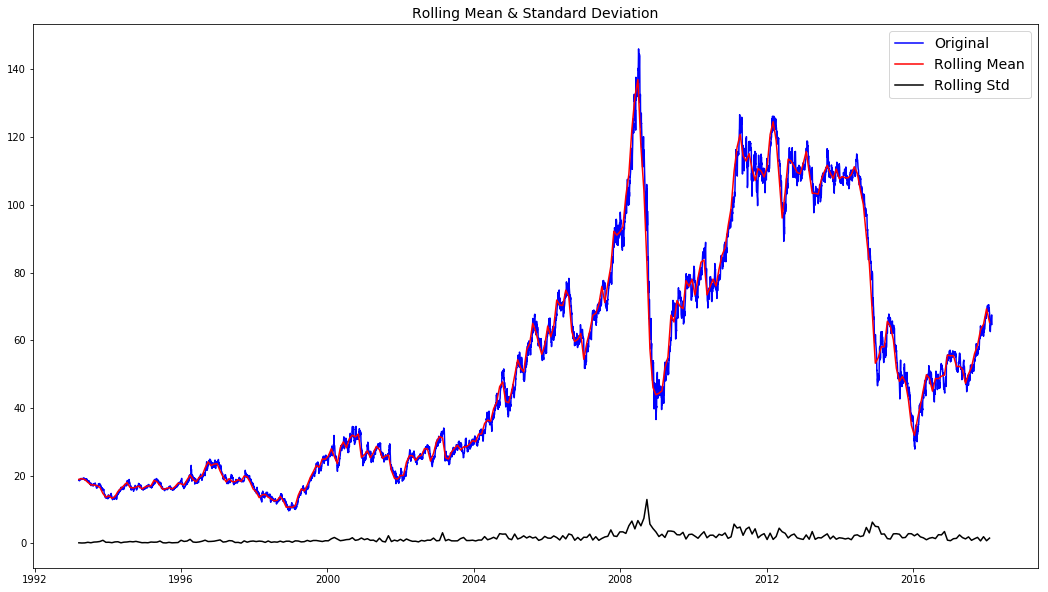

Results of Dickey-Fuller Test:
Test Statistic                   -1.625498
p-value                           0.469848
#Lags Used                       32.000000
Number of Observations Used    6329.000000
Critical Value (1%)              -3.431384
Critical Value (5%)              -2.861997
Critical Value (10%)             -2.567013
dtype: float64


In [22]:
test_stationarity(df_oil_subset)

#### Log Transform the data

In [23]:
df_oil_log = np.log(df_oil_subset)

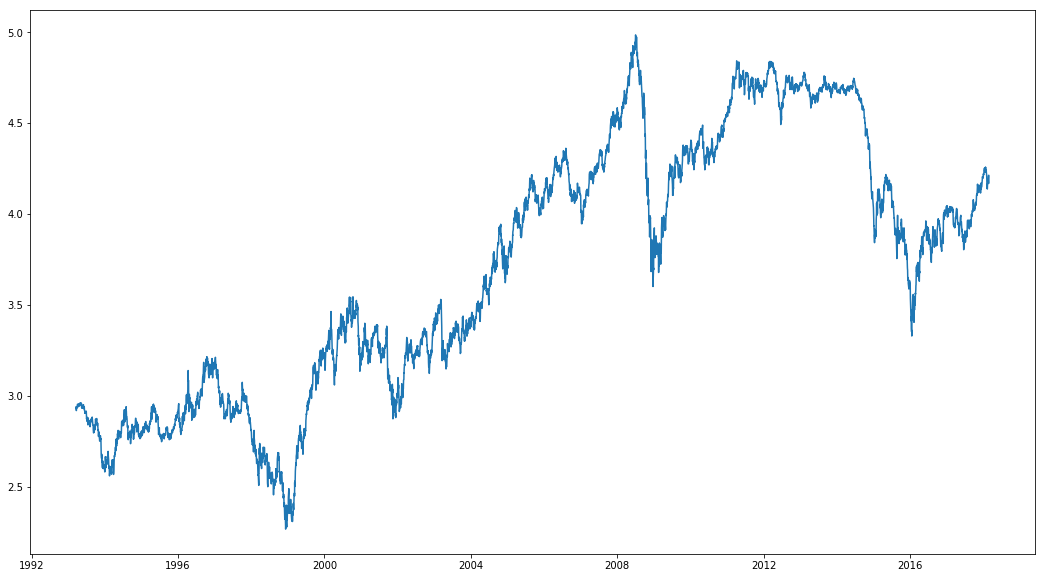

In [25]:
plt.figure(figsize=(18,10))
plt.plot(df_oil_log)

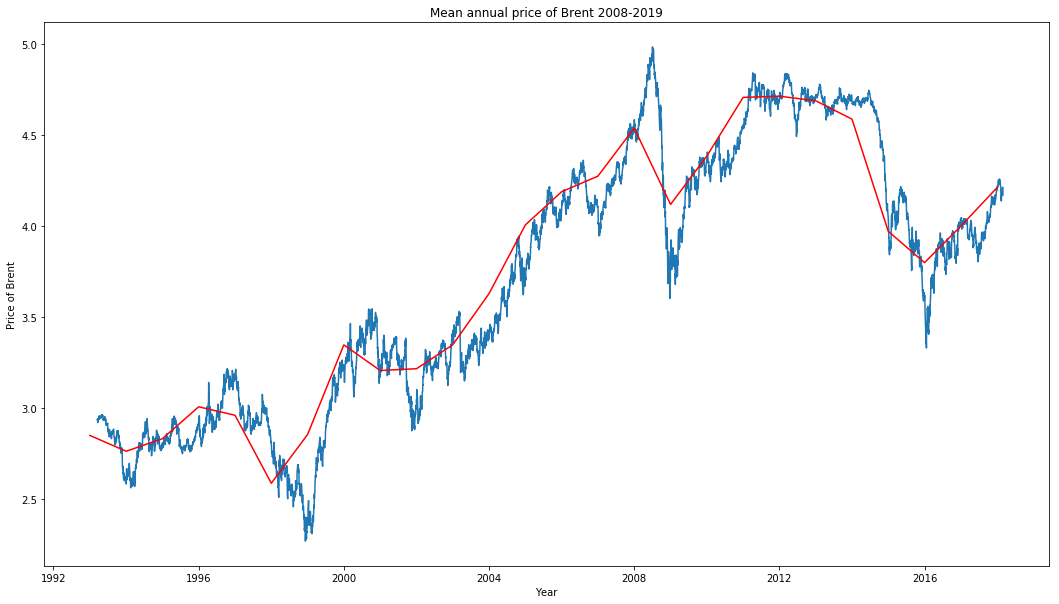

In [26]:
moving_avg = df_oil_log.resample('AS').mean()
plt.figure(figsize=(18,10))
plt.plot(df_oil_log)
plt.plot(moving_avg, color='red')
plt.title('Mean annual price of Brent 2008-2019');
plt.ylabel('Price of Brent');
plt.xlabel('Year');

In [27]:
df_oil_plot = pd.DataFrame(df_oil_subset)

In [28]:
df_oil_plot.columns = ['price']

In [29]:
df_oil_plot['Month'] = df_oil_plot.index.strftime('%b')
df_oil_plot['Year'] = df_oil_plot.index.year
df_oil_plot['DayofWeek'] = df_oil_plot.index.weekday

In [30]:
df_oil_plot.head()

,price,Month,Year,DayofWeek
ds,,,,
2018-02-28,64.73,Feb,2018,2
2018-02-27,66.63,Feb,2018,1
2018-02-26,67.50,Feb,2018,0
2018-02-23,67.31,Feb,2018,4
2018-02-22,66.39,Feb,2018,3


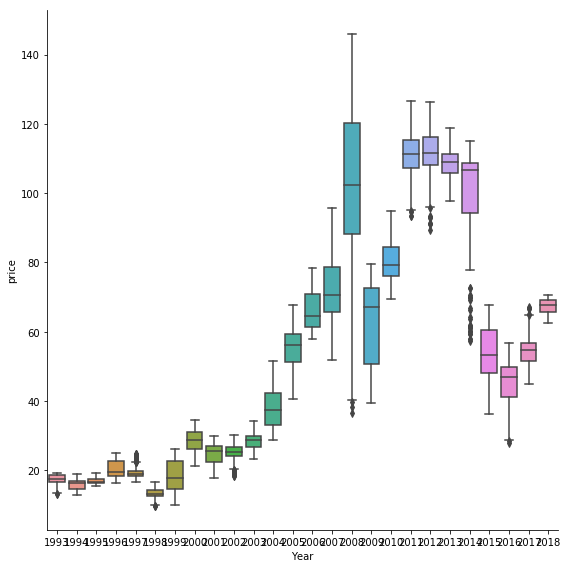

In [31]:
sns.set_palette("hls", n_colors=20)
sns.catplot(
    x='Year',
    y='price',
    data=df_oil_plot,
    kind='box',
    height=8);

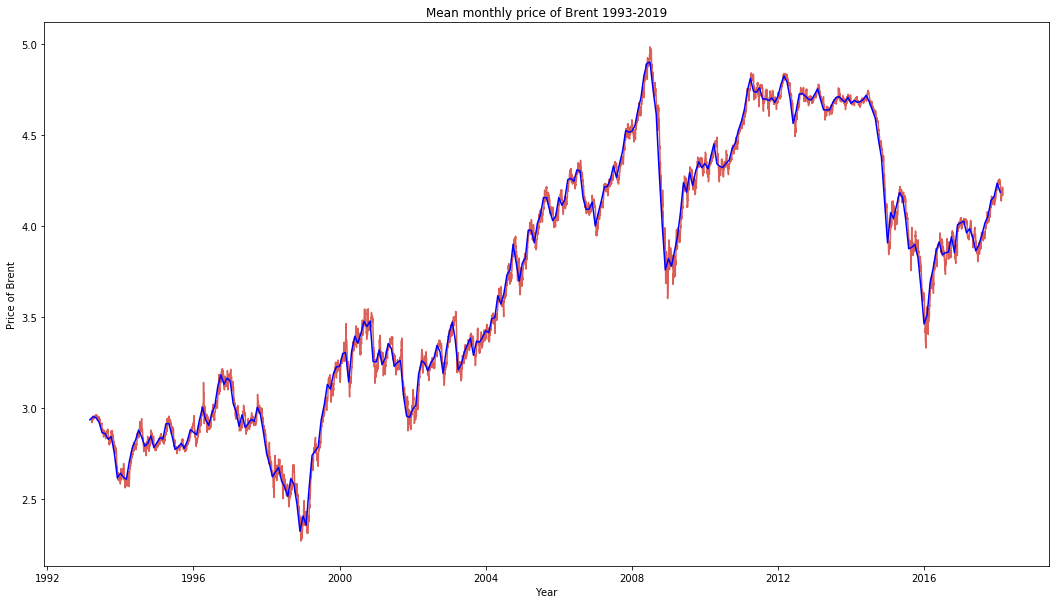

In [32]:
moving_avg_monthly = df_oil_log.resample('MS').mean()
plt.figure(figsize=(18,10))
plt.plot(df_oil_log)
plt.plot(moving_avg_monthly, color='blue')
plt.title('Mean monthly price of Brent 1993-2019');
plt.ylabel('Price of Brent');
plt.xlabel('Year');

In [33]:
moving_avg_m = df_oil_log.resample('M').mean()
ts_log_moving_avg_diff = df_oil_log - moving_avg_m
ts_log_moving_avg_diff.head(12)

ds
1993-03-17         NaN
1993-03-18         NaN
1993-03-19         NaN
1993-03-22         NaN
1993-03-23         NaN
1993-03-24         NaN
1993-03-25         NaN
1993-03-26         NaN
1993-03-29         NaN
1993-03-30         NaN
1993-03-31    0.011573
1993-04-01         NaN
Name: y, dtype: float64

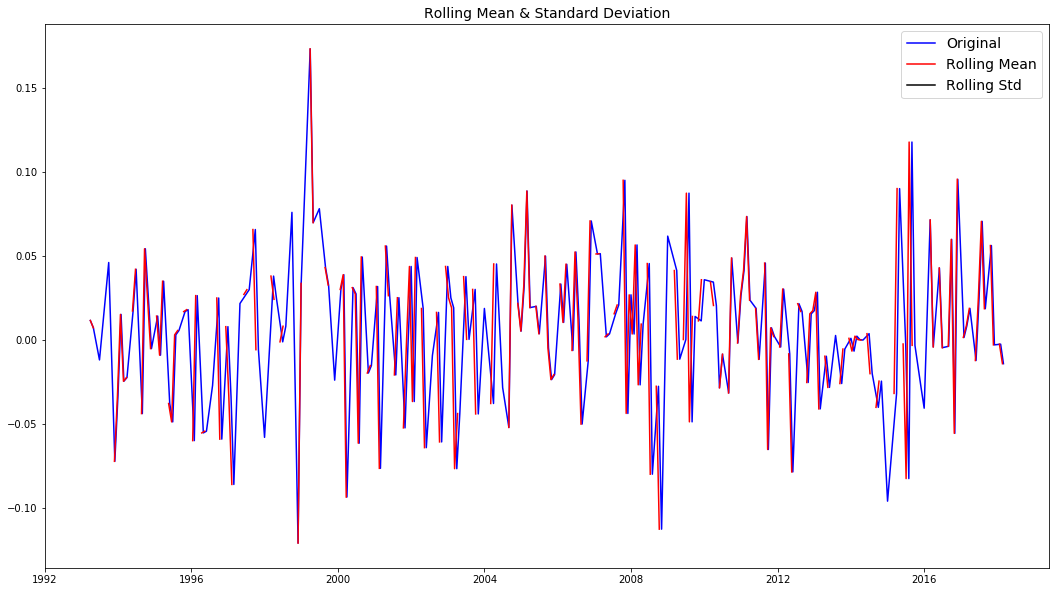

Results of Dickey-Fuller Test:
Test Statistic                -1.578903e+01
p-value                        1.107892e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


In [34]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

##### Dickey Fuller Test, p_value smaller than the 5% critical values so we can say with 95% confidence that we can reject the null hypothesis that the distribution is not stationary

##### Attempt at exponential moving average

In [35]:
expweighted_avg = df_oil_log.ewm(halflife=12)

##### Differencing of the observations at one instance with that of a previous instant to deal with trend and seasonality

In [36]:
expweighted_avg

EWM [com=16.817153745105777,min_periods=0,adjust=True,ignore_na=False,axis=0]

### Log Differentials

In [37]:
ts_log_diff = df_oil_log - df_oil_log.shift(freq='5D')

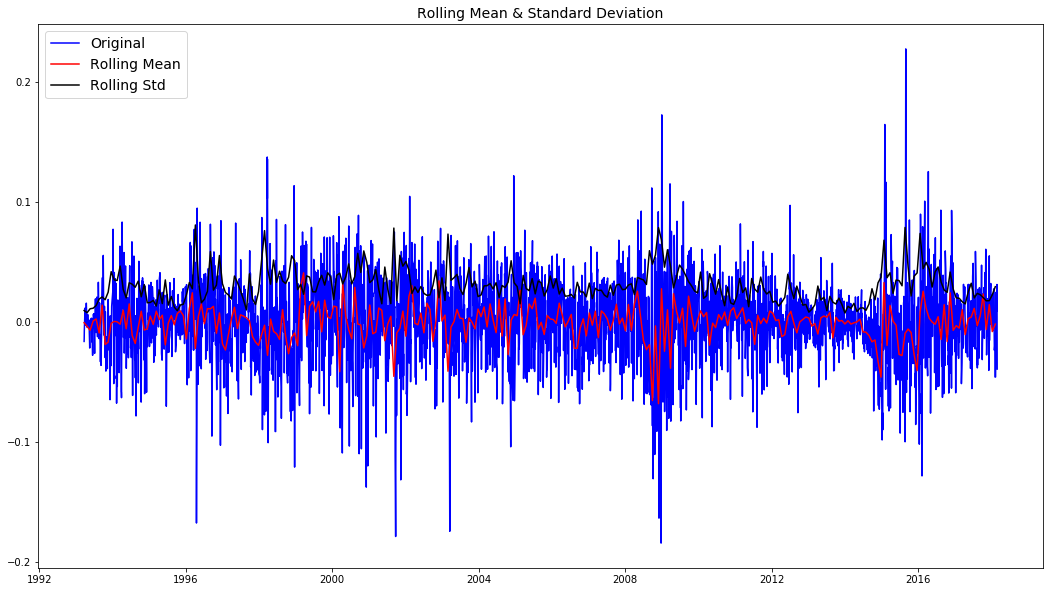

Results of Dickey-Fuller Test:
Test Statistic                  -27.813897
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    3745.000000
Critical Value (1%)              -3.432097
Critical Value (5%)              -2.862312
Critical Value (10%)             -2.567181
dtype: float64


In [38]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

##### Decomposing Method to deal with trend and seasonality

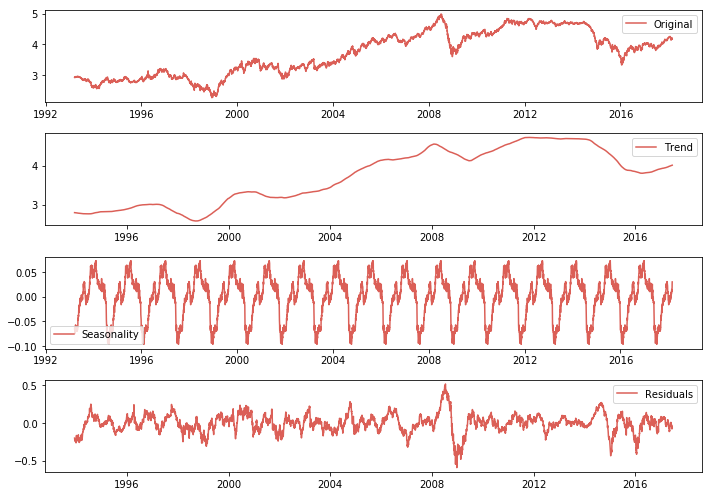

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_oil_log,freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,7))
plt.subplot(411)
plt.plot(df_oil_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

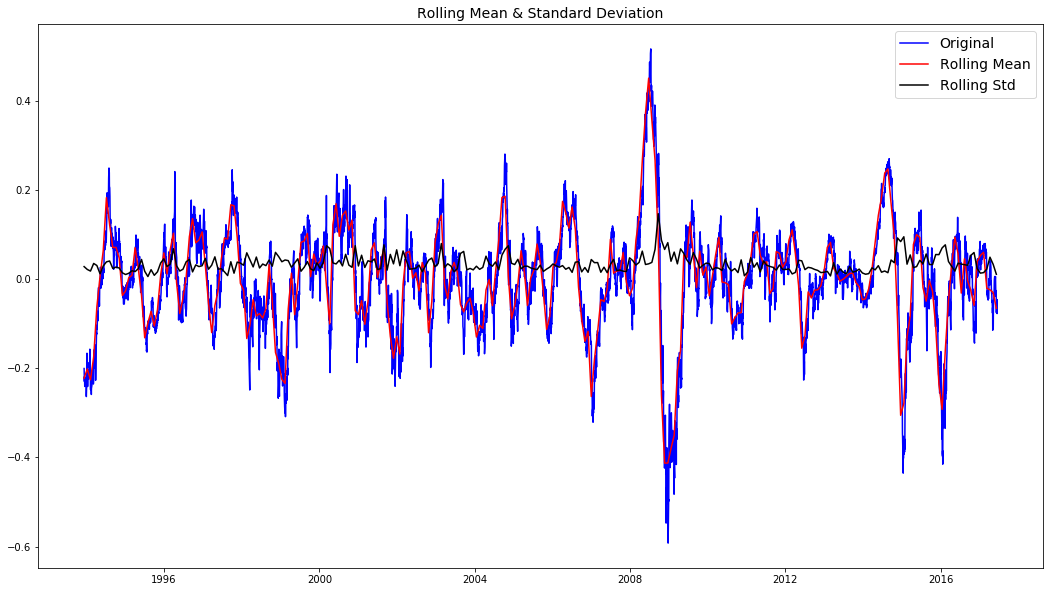

Results of Dickey-Fuller Test:
Test Statistic                -6.812105e+00
p-value                        2.103510e-09
#Lags Used                     1.600000e+01
Number of Observations Used    5.981000e+03
Critical Value (1%)           -3.431444e+00
Critical Value (5%)           -2.862023e+00
Critical Value (10%)          -2.567027e+00
dtype: float64


In [40]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecast Time Series

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

### Determine p and q

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [41]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [42]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

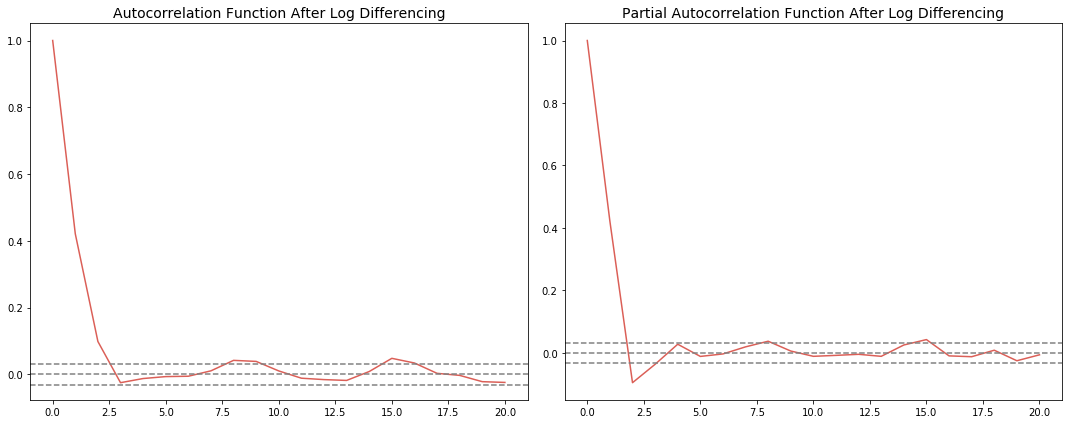

In [43]:
#Plot ACF:
plt.figure(figsize=(15,6))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function After Log Differencing',fontsize=14)

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function After Log Differencing', fontsize=14)
plt.tight_layout()

In [44]:
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [132]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax, color='steelblue')
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25, color='steelblue')
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color='steelblue')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, color='steelblue')
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

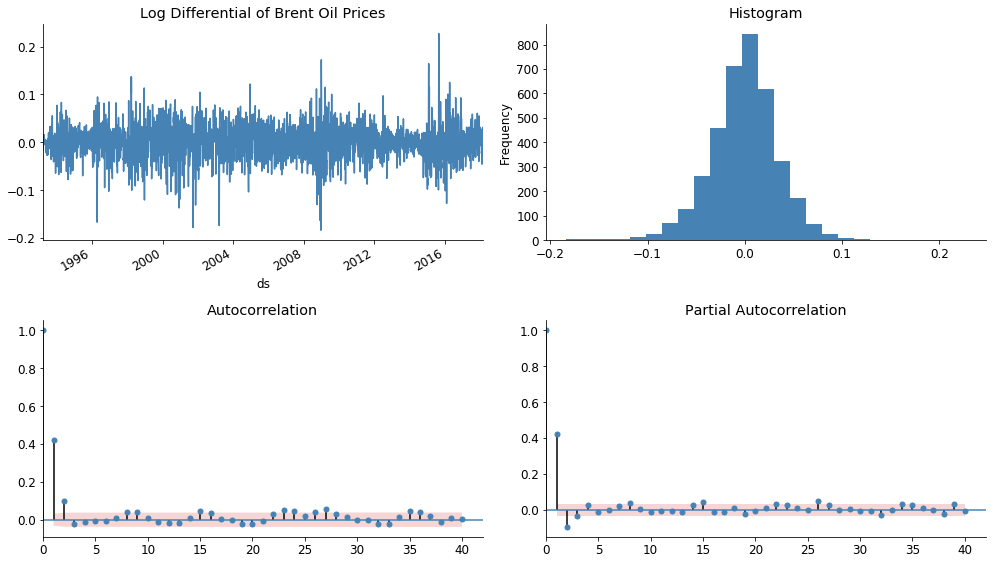

In [133]:
tsplot(ts_log_diff, title='Log Differential of Brent Oil Prices', lags=40);

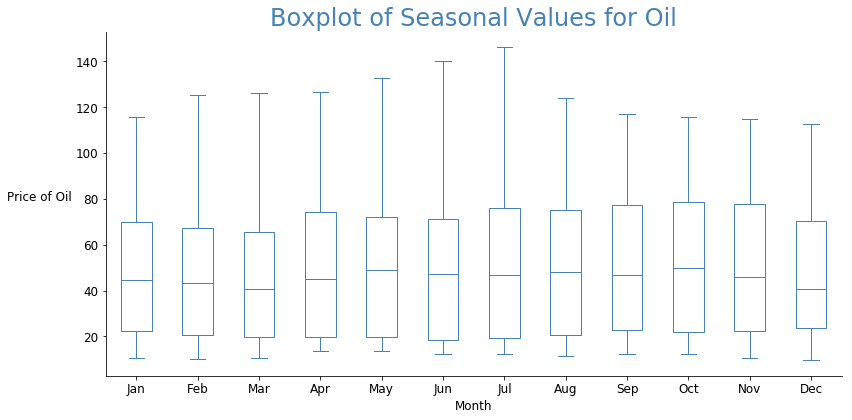

In [152]:
# An alternative way to detect seasonality

df_oil_plot['Month'] = df_oil_plot.index.strftime('%b')
df_oil_plot['Year'] = df_oil_plot.index.year

ts_piv = df_oil_plot.pivot(columns='Month', values='price')

df_oil_plot = df_oil_plot.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2018-01-01', periods=12, freq='MS').strftime('%b')
ts_piv = ts_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(12, 6))
ts_piv.plot(ax=ax, kind='box', color='steelblue');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Month', color=);
ax.set_ylabel('Price of Oil', rotation='horizontal',ha='right');
ax.set_title('Boxplot of Seasonal Values for Oil', color='steelblue', fontsize=24);
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

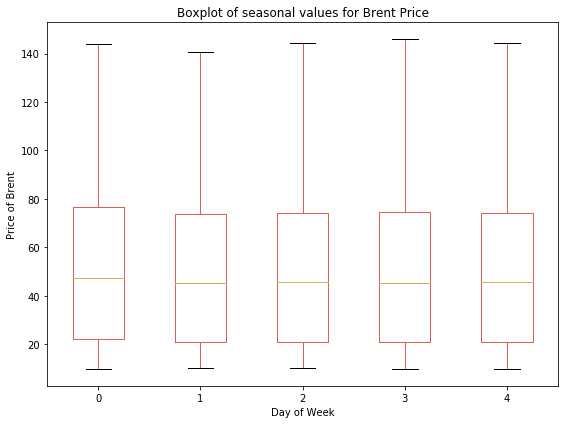

In [48]:
df_oil_plot['DayofWeek'] = df_oil_plot.index.weekday

ts_piv = df_oil_plot.pivot(columns='DayofWeek', values='price')

df_oil_plot = df_oil_plot.drop(['DayofWeek'], axis=1)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
ts_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Day of Week');
ax.set_ylabel('Price of Brent');
ax.set_title('Boxplot of seasonal values for Brent Price');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

#### Build ARIMA Model for Forecasting

In [49]:
# #train_results = sm.tsa.arma_order_select_ic(ts_log_diff, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
# train_results = sm.tsa.arma_order_select_ic(ts_log_diff, ic=['aic', 'bic'], max_ar=20, max_ma=2)
# print('AIC', train_results.aic_min_order)
# print('BIC', train_results.bic_min_order)

In [50]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 0
q_max = 2

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_log_diff, order=(p, d, q), 
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has

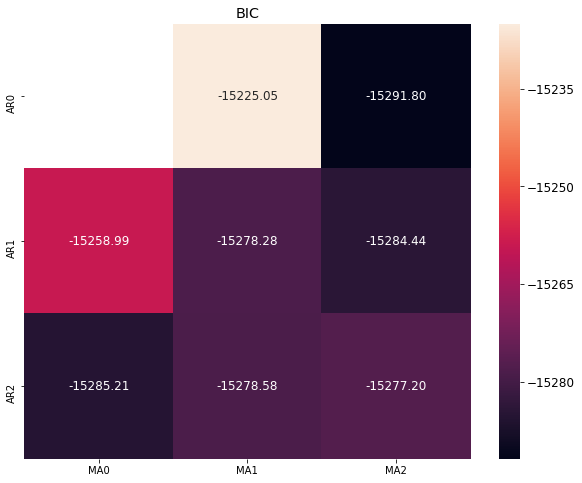

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

## Build a time series model with ARIMA

In [52]:
from statsmodels.tsa.arima_model import ARIMA

### AR Model, since I am already using log_diff, won't need to to specify d 

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/robfang29/anaconda3/lib/python3.

Text(0.5, 1.0, 'RSS: 3.6965')

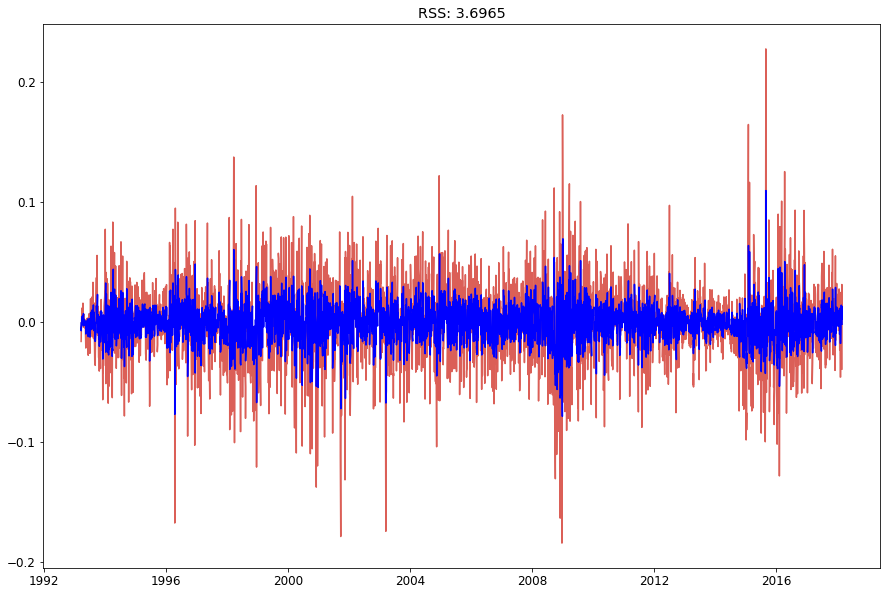

In [53]:
model = ARIMA(ts_log_diff, order=(2, 0, 0))  
results_AR = model.fit()  
plt.figure(figsize=(15,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [54]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3749
Model:                     ARMA(2, 0)   Log Likelihood                7655.340
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 13 Jun 2019   AIC                         -15302.680
Time:                        11:38:24   BIC                         -15277.763
Sample:                             0   HQIC                        -15293.818
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.882      0.378      -0.002       0.001
ar.L1.y        0.4613      0.016     28.376      0.000       0.429       0.493
ar.L2.y       -0.0958      0.016     -5.894      0.000      -0.128      -0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4073           -2.1543j            3.2305           -0.1162
AR.2            2.4073           +2.1543j            3.2305            0.1162
-----------------------------------------------------------------------------
"""

### MA Model

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 3.6900')

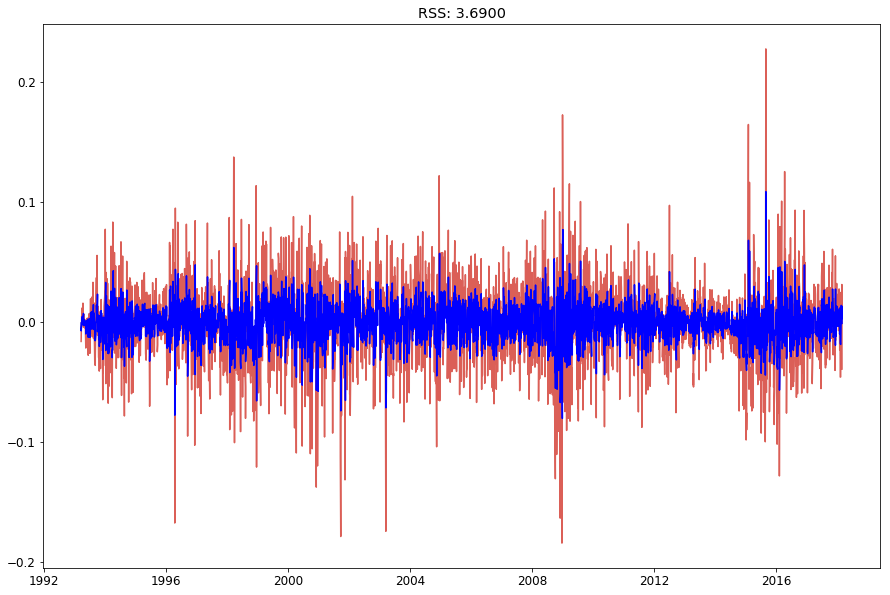

In [55]:
model = ARIMA(ts_log_diff, order=(0, 0, 2))  
results_MA = model.fit()  
plt.figure(figsize=(15,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [56]:
results_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3749
Model:                     ARMA(0, 2)   Log Likelihood                7658.619
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 13 Jun 2019   AIC                         -15309.239
Time:                        11:38:24   BIC                         -15284.322
Sample:                             0   HQIC                        -15300.377
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.867      0.386      -0.002       0.001
ma.L1.y        0.4621      0.016     28.409      0.000       0.430       0.494
ma.L2.y        0.1445      0.016      8.773      0.000       0.112       0.177
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.5993           -2.0892j            2.6311           -0.3540
MA.2           -1.5993           +2.0892j            2.6311            0.3540
-----------------------------------------------------------------------------
"""

### Combined Model

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 3.7030')

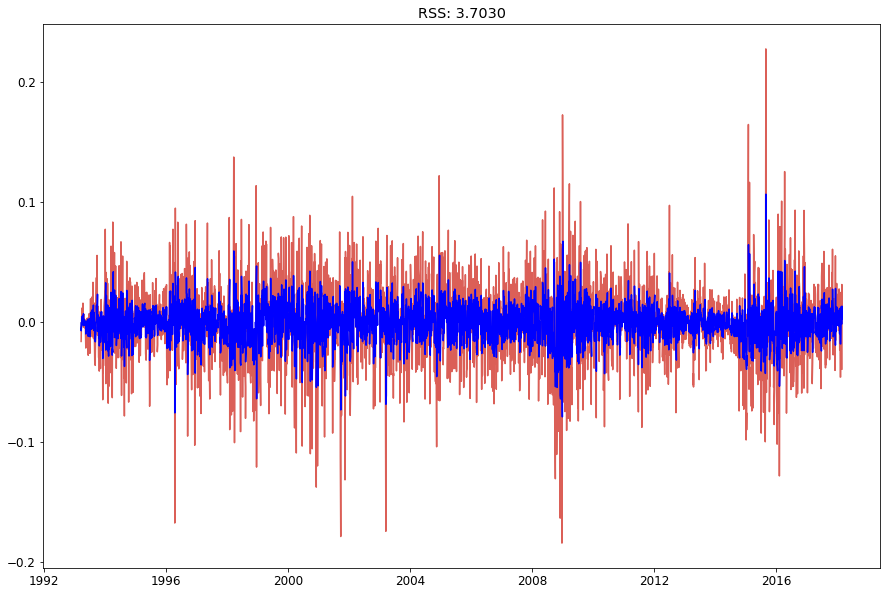

In [57]:
model = ARIMA(ts_log_diff, order=(1, 0, 1))  
results_ARIMA = model.fit()  
plt.figure(figsize=(15,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [58]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3749
Model:                     ARMA(1, 1)   Log Likelihood                7652.052
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 13 Jun 2019   AIC                         -15296.104
Time:                        11:38:25   BIC                         -15271.187
Sample:                             0   HQIC                        -15287.242
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.853      0.394      -0.002       0.001
ar.L1.y        0.2769      0.033      8.477      0.000       0.213       0.341
ma.L1.y        0.1784      0.033      5.481      0.000       0.115       0.242
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.6116           +0.0000j            3.6116            0.0000
MA.1           -5.6041           +0.0000j            5.6041            0.5000
-----------------------------------------------------------------------------
"""

In [59]:
# Fit the model
arima200 = sm.tsa.SARIMAX(ts_log_diff, order=(1,0,1))
model_results = arima200.fit()
model_results.summary()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3749
Model:               SARIMAX(1, 0, 1)   Log Likelihood                7651.483
Date:                Thu, 13 Jun 2019   AIC                         -15296.967
Time:                        11:38:26   BIC                         -15278.279
Sample:                             0   HQIC                        -15290.321
                               - 3749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2592      0.029      9.012      0.000       0.203       0.316
ma.L1          0.1989      0.030      6.578      0.000       0.140       0.258
sigma2         0.0010   1.47e-05     67.228      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       71.71   Jarque-Bera (JB):              1521.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

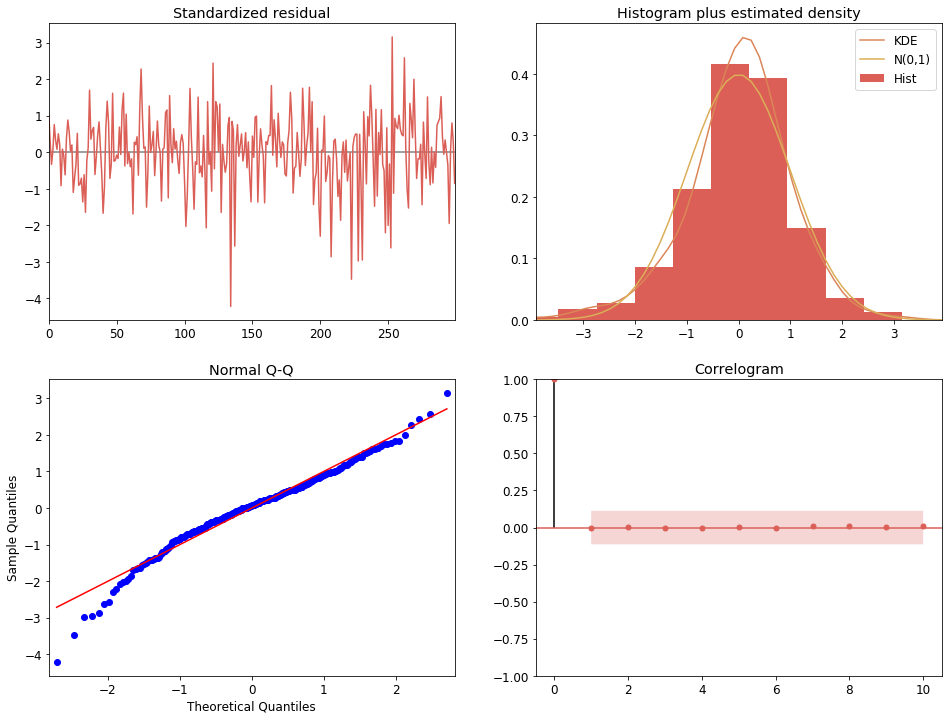

In [134]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics(figsize=(16, 12));

## ARIMA Modeling for In Sample Dataset

In [61]:
ts_train = df_oil[df_oil['ds'] <= '2019-03-01']

In [62]:
ts_train = ts_train[ts_train['ds'] >= '2018-01-02']

In [63]:
ts_train.index = ts_train['ds']

In [64]:
ts_train = ts_train['y']

In [65]:
ts_test = df_oil_test

In [66]:
ts_train.isnull().sum()

0

In [67]:
ts_train.fillna(method='ffill', inplace=True)

In [68]:
ts_train.sort_index(inplace=True)

In [69]:
ts_test.sort_index(inplace=True)

/Users/robfang29/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:2984: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [70]:
print("Training Series:", "\n", ts_train.head(), "\n")
print("Testing Series:", "\n", ts_test.tail())

Training Series: 
 ds
2018-01-02    66.57
2018-01-03    67.84
2018-01-04    68.07
2018-01-05    67.62
2018-01-08    67.78
Name: y, dtype: float64 

Testing Series: 
 ds
2019-05-27    70.11
2019-05-28    70.11
2019-05-29    69.45
2019-05-30    66.87
2019-05-31    64.49
Name: y, dtype: float64


/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



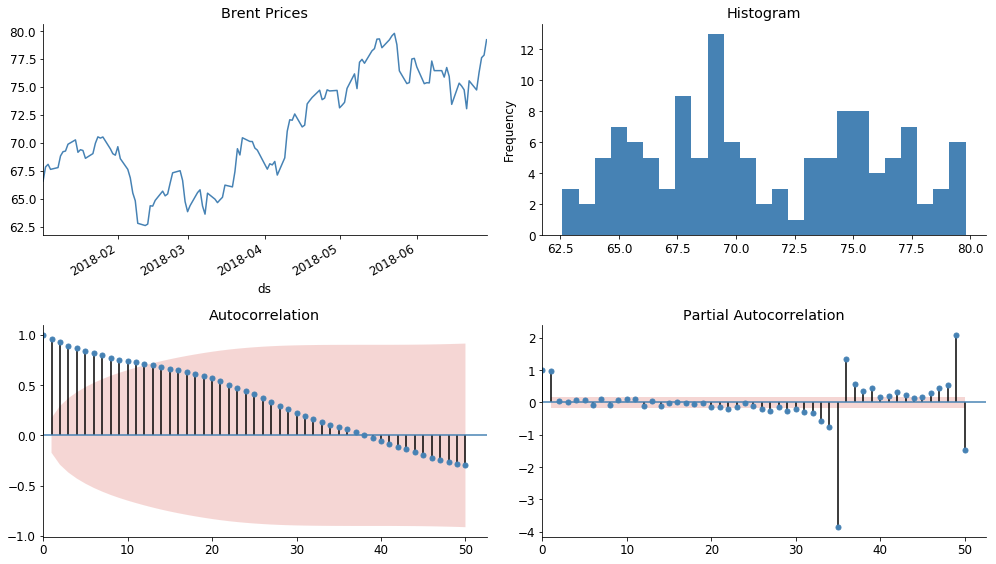

In [136]:
tsplot(ts_train, title='Brent Prices', lags=50);

In [72]:
type(ts_train)
type(ts_train.index)
ts_train.head()

ds
2018-01-02    66.57
2018-01-03    67.84
2018-01-04    68.07
2018-01-05    67.62
2018-01-08    67.78
Name: y, dtype: float64

In [98]:
# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(20,1,2))
model_results = arima200.fit()
model_results.summary()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  301
Model:              SARIMAX(20, 1, 2)   Log Likelihood                -480.222
Date:                Thu, 13 Jun 2019   AIC                           1006.445
Time:                        11:40:42   BIC                           1091.632
Sample:                             0   HQIC                          1040.537
                                - 301                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4698      1.152      0.408      0.683      -1.788       2.728
ar.L2         -0.0912      0.772     -0.118      0.906      -1.604       1.422
ar.L3          0.0501      0.089      0.566      0.571      -0.124       0.224
ar.L4          0.0583      0.108      0.541      0.589      -0.153       0.270
ar.L5          0.0312      0.088      0.354      0.723      -0.141       0.204
ar.L6          0.0026      0.084      0.031      0.975      -0.162       0.167
ar.L7         -0.0310      0.088     -0.352      0.725      -0.204       0.142
ar.L8          0.0838      0.096      0.870      0.385      -0.105       0.273
ar.L9         -0.1064      0.128     -0.833      0.405      -0.357       0.144
ar.L10         0.0223      0.154      0.145      0.885      -0.279       0.324
ar.L11        -0.0546      0.083     -0.654      0.513      -0.218       0.109
ar.L12         0.0150      0.084      0.179      0.858      -0.150       0.180
ar.L13        -0.0359      0.076     -0.471      0.637      -0.185       0.113
ar.L14         0.0308      0.072      0.426      0.670      -0.111       0.173
ar.L15         0.0575      0.086      0.668      0.504      -0.111       0.226
ar.L16        -0.0574      0.097     -0.594      0.552      -0.247       0.132
ar.L17         0.0386      0.113      0.342      0.732      -0.182       0.260
ar.L18         0.0493      0.091      0.541      0.589      -0.129       0.228
ar.L19         0.0386      0.087      0.444      0.657      -0.132       0.209
ar.L20         0.0699      0.092      0.759      0.448      -0.111       0.250
ma.L1         -0.5815      1.143     -0.509      0.611      -2.822       1.659
ma.L2          0.1214      0.889      0.137      0.891      -1.620       1.863
sigma2         1.4350      0.108     13.296      0.000       1.223       1.646
===================================================================================
Ljung-Box (Q):                       14.74   Jarque-Bera (JB):                50.54
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

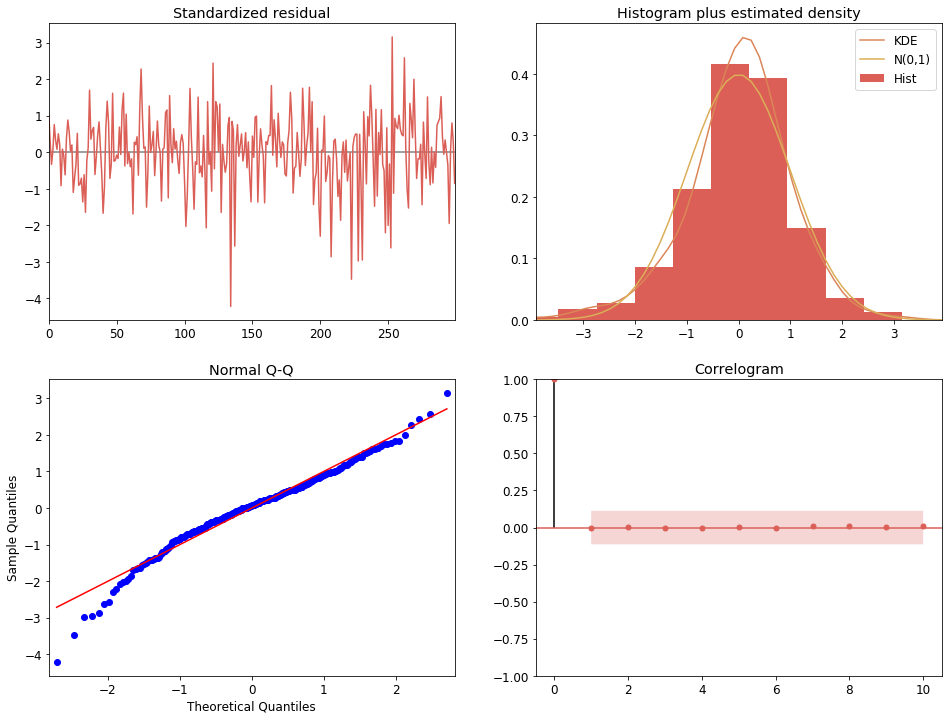

In [99]:
model_results.plot_diagnostics(figsize=(16, 12));

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



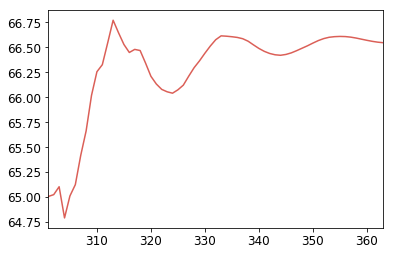

In [100]:
model_results.forecast(63).plot()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



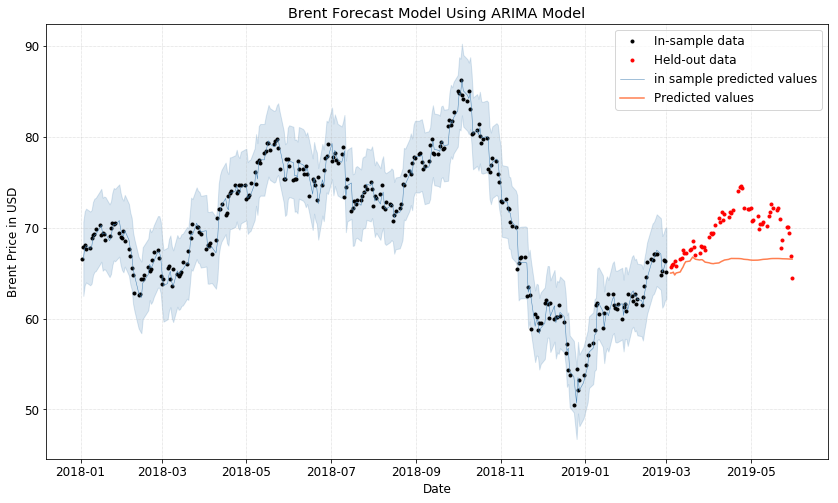

In [102]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    
ax1.plot(ts_train, 'ko', label='In-sample data', markersize=3)
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, 'ro', label='Held-out data', markersize=3)

# yes DatetimeIndex
pred_begin = ts_train.index[0]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start = 1, end = 300)
pred_2 = model_results.forecast(64)
pred_2.index = ts_test.index
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.001)


ax1.plot(pred_mean, color='steelblue', lw=0.5, label='in sample predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='steelblue', alpha=.2)
ax1.plot(pred_2, 'coral', alpha=1, label='Predicted values')

ax1.legend(loc='best')
ax1.grid(ls=':', lw=0.5)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Brent Price in USD", fontsize=12)
plt.title('Brent Forecast Model Using ARIMA Model' );

In [103]:
df_rmse = pd.DataFrame(ts_test.copy())

In [104]:
df_rmse['yhat'] = pred_2.values

In [105]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



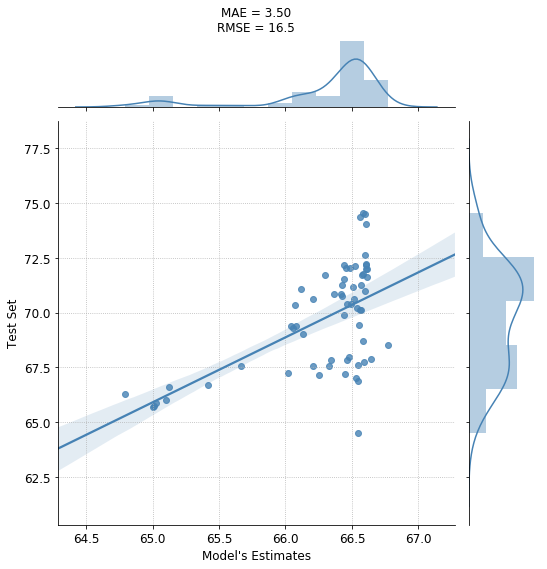

In [106]:
g = sns.jointplot(x='yhat', y='y', data = df_rmse, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values), RMSE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

## Fit SARIMA Model

In [107]:
def rolling_period(forecast_date):
    ts_train = df_oil[df_oil['ds'] <= forecast_date]
    ts_train = ts_train[ts_train['ds'] >= '2018-01-02']
    ts_train.index = ts_train['ds']
    ts_train = ts_train['y']
    ts_test = df_oil[df_oil['ds'] > forecast_date]
    ts_test.index = ts_test['ds']
    ts_test = ts_test['y']
    ts_train.sort_index(inplace=True)
    ts_test.sort_index(inplace=True)
    return ts_train, ts_test

In [108]:
ts_train, ts_test = rolling_period('2019-03-01')

/Users/robfang29/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:2984: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [109]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(ts_train, order=(20,1,0), seasonal_order=(0,1,0,20)).fit()
sar.summary()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  301
Model:             SARIMAX(20, 1, 0)x(0, 1, 0, 20)   Log Likelihood                -509.013
Date:                             Thu, 13 Jun 2019   AIC                           1060.027
Time:                                     11:41:06   BIC                           1136.357
Sample:                                          0   HQIC                          1090.643
                                             - 301                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1189      0.063     -1.894      0.058      -0.242       0.004
ar.L2          0.0028      0.060      0.046      0.963      -0.114       0.120
ar.L3          0.0070      0.057      0.124      0.902      -0.104       0.118
ar.L4          0.0701      0.063      1.110      0.267      -0.054       0.194
ar.L5          0.0682      0.063      1.082      0.279      -0.055       0.192
ar.L6          0.0281      0.060      0.468      0.640      -0.090       0.146
ar.L7          0.0201      0.065      0.308      0.758      -0.108       0.148
ar.L8          0.0614      0.058      1.060      0.289      -0.052       0.175
ar.L9         -0.0336      0.062     -0.546      0.585      -0.154       0.087
ar.L10         0.0500      0.054      0.921      0.357      -0.056       0.156
ar.L11        -0.0518      0.061     -0.855      0.393      -0.170       0.067
ar.L12        -0.0231      0.061     -0.380      0.704      -0.142       0.096
ar.L13        -0.0131      0.055     -0.238      0.812      -0.121       0.095
ar.L14        -0.0226      0.068     -0.333      0.739      -0.156       0.110
ar.L15         0.0380      0.054      0.701      0.483      -0.068       0.144
ar.L16         0.0203      0.055      0.372      0.710      -0.087       0.128
ar.L17         0.0209      0.063      0.333      0.739      -0.102       0.144
ar.L18         0.1258      0.064      1.970      0.049       0.001       0.251
ar.L19         0.1115      0.058      1.907      0.056      -0.003       0.226
ar.L20        -0.3848      0.061     -6.331      0.000      -0.504      -0.266
sigma2         2.1870      0.183     11.927      0.000       1.828       2.546
===================================================================================
Ljung-Box (Q):                       45.11   Jarque-Bera (JB):                15.16
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

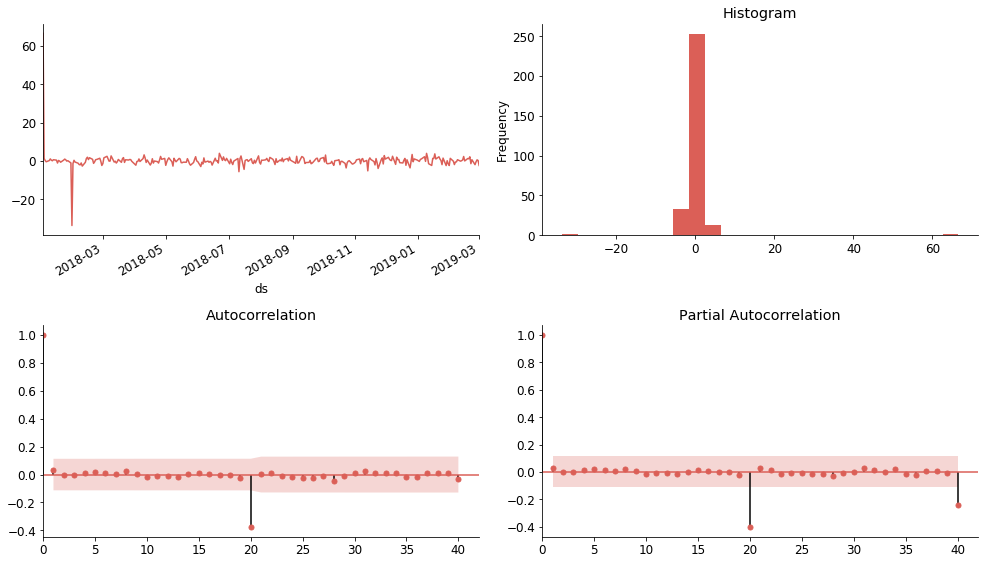

In [110]:
tsplot(sar.resid, lags=40);

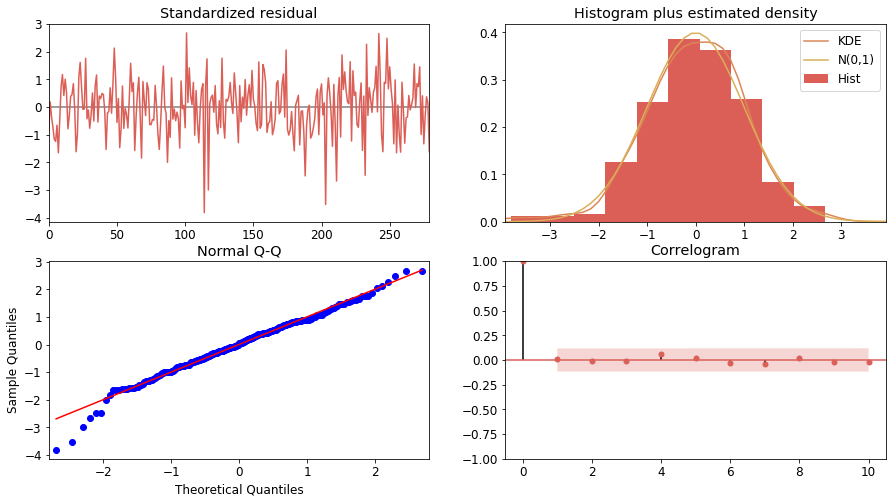

In [111]:
sar.plot_diagnostics(figsize=(15, 8));

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



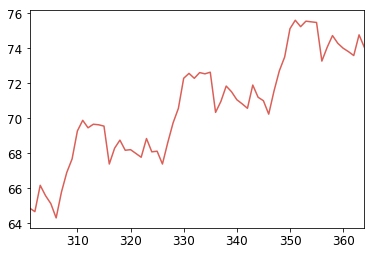

In [112]:
sar.forecast(len(ts_test)).plot()

In [113]:
ts_train.head()

ds
2018-01-02    66.57
2018-01-03    67.84
2018-01-04    68.07
2018-01-05    67.62
2018-01-08    67.78
Name: y, dtype: float64

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



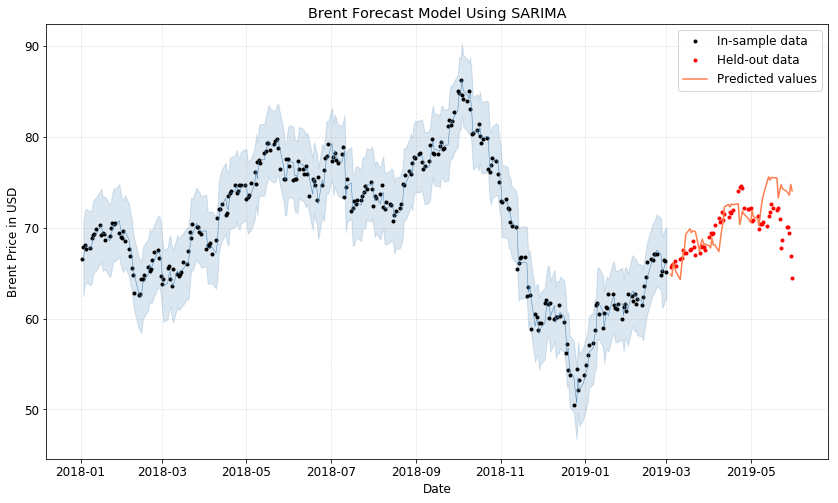

In [114]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    
ax1.plot(ts_train, 'ko', label='In-sample data', markersize=3)
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, 'ro', label='Held-out data', markersize=3)

# yes DatetimeIndex
pred_begin = ts_train.index[0]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start = 1, end = 300)
pred_2 = sar.forecast(len(ts_test))
pred_2.index = ts_test.index
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.001)


ax1.plot(pred_mean, color='steelblue', lw=0.5,)
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='steelblue', alpha=.2)
ax1.plot(pred_2, 'coral', alpha=1, label='Predicted values')

ax1.legend(loc='best')
ax1.grid(ls=':', lw=0.5)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Brent Price in USD", fontsize=12)
plt.title('Brent Forecast Model Using SARIMA' );

In [115]:
df_rmse = pd.DataFrame(ts_test.copy())

In [116]:
df_rmse['yhat'] = pred_2.values

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



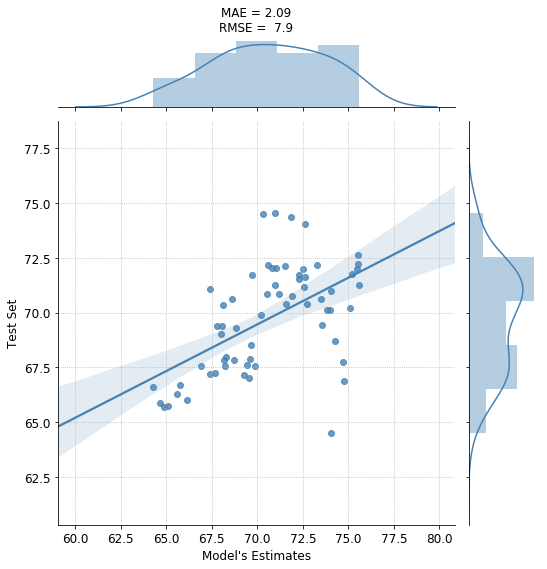

In [117]:
df_rmse = pd.DataFrame(ts_test.copy())
df_rmse['yhat'] = pred_2.values

g = sns.jointplot(x='yhat', y='y', data = df_rmse, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values), RMSE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

## Rolling Validation Test

In [118]:
ts_train, ts_test = rolling_period('2019-01-01')

/Users/robfang29/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:2984: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [119]:
sar = sm.tsa.statespace.SARIMAX(ts_train, order=(20,1,0), seasonal_order=(0,1,0,20), trend='c').fit()
sar.summary()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  258
Model:             SARIMAX(20, 1, 0)x(0, 1, 0, 20)   Log Likelihood                -426.115
Date:                             Thu, 13 Jun 2019   AIC                            896.230
Time:                                     11:41:14   BIC                            972.528
Sample:                                          0   HQIC                           926.983
                                             - 258                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0522      0.110     -0.473      0.636      -0.268       0.164
ar.L1         -0.1351      0.071     -1.906      0.057      -0.274       0.004
ar.L2         -0.0432      0.068     -0.634      0.526      -0.177       0.090
ar.L3      -9.807e-05      0.067     -0.001      0.999      -0.132       0.132
ar.L4          0.0433      0.072      0.600      0.548      -0.098       0.185
ar.L5          0.0817      0.073      1.122      0.262      -0.061       0.224
ar.L6          0.0300      0.070      0.431      0.666      -0.106       0.167
ar.L7          0.0275      0.069      0.395      0.693      -0.109       0.164
ar.L8          0.0557      0.068      0.815      0.415      -0.078       0.190
ar.L9         -0.0264      0.068     -0.386      0.700      -0.160       0.108
ar.L10         0.0918      0.065      1.411      0.158      -0.036       0.219
ar.L11        -0.0016      0.070     -0.022      0.982      -0.139       0.136
ar.L12        -0.0047      0.067     -0.070      0.944      -0.137       0.127
ar.L13         0.0101      0.063      0.161      0.872      -0.113       0.133
ar.L14         0.0060      0.074      0.080      0.936      -0.140       0.152
ar.L15         0.0550      0.064      0.860      0.390      -0.070       0.180
ar.L16         0.0395      0.068      0.581      0.561      -0.094       0.173
ar.L17        -0.0211      0.078     -0.269      0.788      -0.175       0.132
ar.L18         0.0832      0.076      1.092      0.275      -0.066       0.232
ar.L19         0.0828      0.071      1.169      0.242      -0.056       0.222
ar.L20        -0.4175      0.068     -6.141      0.000      -0.551      -0.284
sigma2         2.0907      0.192     10.868      0.000       1.714       2.468
===================================================================================
Ljung-Box (Q):                       33.60   Jarque-Bera (JB):                24.91
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.45
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



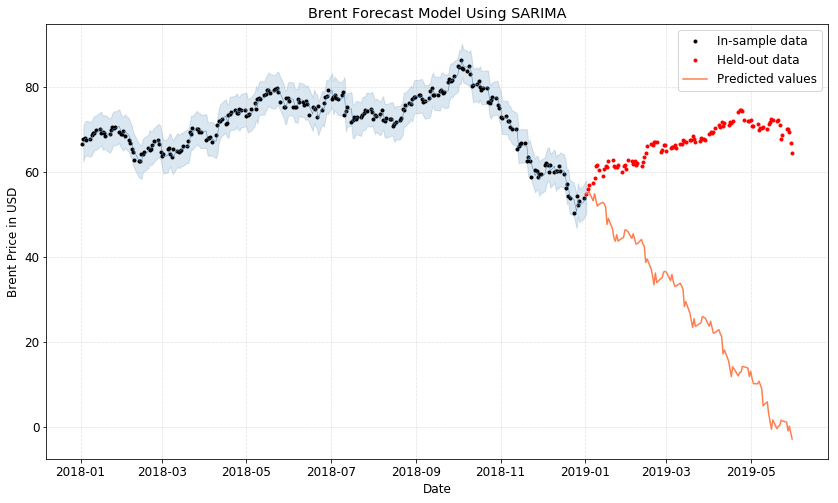

In [120]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    
ax1.plot(ts_train, 'ko', label='In-sample data', markersize=3)
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, 'ro', label='Held-out data', markersize=3)

# yes DatetimeIndex
pred_begin = ts_train.index[0]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start = 1, end = len(ts_train))
pred_2 = sar.forecast(len(ts_test))
pred_2.index = ts_test.index
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.001)


ax1.plot(pred_mean, color='steelblue', lw=0.5)
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='steelblue', alpha=.2)
ax1.plot(pred_2, 'coral', alpha=1, label='Predicted values')

ax1.legend(loc='best')
ax1.grid(ls=':', lw=0.5)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Brent Price in USD", fontsize=12)
plt.title('Brent Forecast Model Using SARIMA' );

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



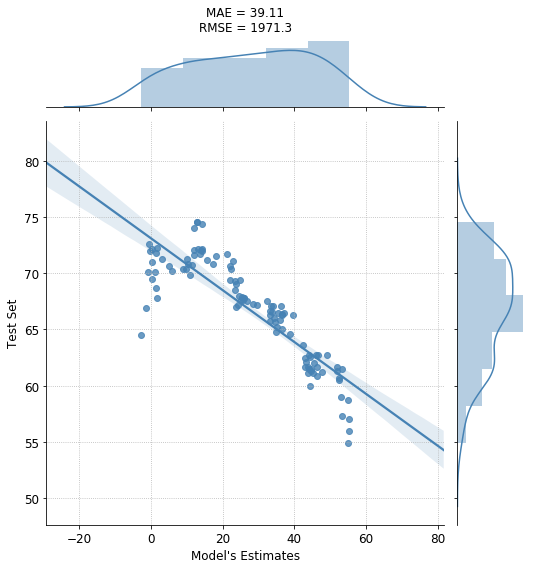

In [121]:
df_rmse = pd.DataFrame(ts_test.copy())
df_rmse['yhat'] = pred_2.values

g = sns.jointplot(x='yhat', y='y', data = df_rmse, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values), RMSE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')

In [122]:
ts_train, ts_test = rolling_period('2018-07-01')

/Users/robfang29/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:2984: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [123]:
sar = sm.tsa.statespace.SARIMAX(ts_train, order=(20,1,0), seasonal_order=(0,1,0,20), trend='c').fit()
sar.summary()

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  128
Model:             SARIMAX(20, 1, 0)x(0, 1, 0, 20)   Log Likelihood                -171.999
Date:                             Thu, 13 Jun 2019   AIC                            387.999
Time:                                     11:41:19   BIC                            446.801
Sample:                                          0   HQIC                           411.836
                                             - 128                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0158      0.159      0.100      0.921      -0.295       0.327
ar.L1         -0.0007      0.106     -0.007      0.995      -0.209       0.207
ar.L2         -0.0445      0.100     -0.444      0.657      -0.241       0.152
ar.L3         -0.0802      0.110     -0.727      0.467      -0.296       0.136
ar.L4          0.0479      0.121      0.398      0.691      -0.188       0.284
ar.L5          0.0232      0.099      0.235      0.815      -0.171       0.217
ar.L6          0.1140      0.116      0.985      0.325      -0.113       0.341
ar.L7          0.1161      0.092      1.256      0.209      -0.065       0.297
ar.L8          0.0029      0.117      0.025      0.980      -0.227       0.232
ar.L9          0.0390      0.115      0.339      0.734      -0.186       0.265
ar.L10         0.0034      0.122      0.028      0.978      -0.235       0.242
ar.L11         0.0878      0.123      0.712      0.476      -0.154       0.329
ar.L12        -0.0391      0.097     -0.403      0.687      -0.229       0.151
ar.L13         0.2292      0.105      2.183      0.029       0.023       0.435
ar.L14         0.0047      0.114      0.041      0.967      -0.219       0.228
ar.L15        -0.0763      0.122     -0.623      0.533      -0.316       0.164
ar.L16         0.0116      0.115      0.101      0.919      -0.213       0.236
ar.L17        -0.0863      0.135     -0.640      0.522      -0.350       0.178
ar.L18        -0.0327      0.110     -0.296      0.767      -0.249       0.184
ar.L19        -0.1022      0.118     -0.865      0.387      -0.334       0.129
ar.L20        -0.5082      0.114     -4.445      0.000      -0.732      -0.284
sigma2         1.3574      0.252      5.389      0.000       0.864       1.851
===================================================================================
Ljung-Box (Q):                       28.74   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.91   Prob(JB):                         0.31
Heteroskedasticity (H):               1.06   Skew:                             0.36
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/robfang29/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



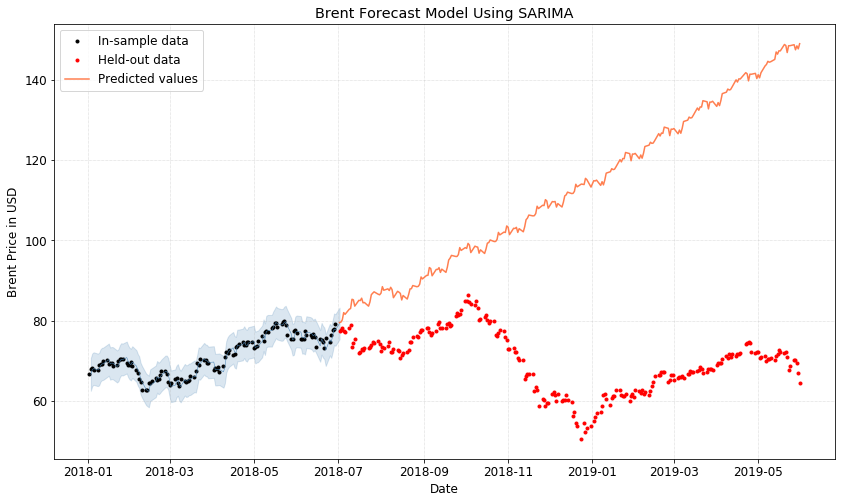

In [124]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    
ax1.plot(ts_train, 'ko', label='In-sample data', markersize=3)
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, 'ro', label='Held-out data', markersize=3)

# yes DatetimeIndex
pred_begin = ts_train.index[0]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start = 1, end = len(ts_train))
pred_2 = sar.forecast(len(ts_test))
pred_2.index = ts_test.index
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.001)


ax1.plot(pred_mean, color='steelblue', lw=0.5)
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='steelblue', alpha=.2)
ax1.plot(pred_2, 'coral', alpha=1, label='Predicted values')

ax1.legend(loc='best')
ax1.grid(ls=':', lw=0.5)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Brent Price in USD", fontsize=12)
plt.title('Brent Forecast Model Using SARIMA' );

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



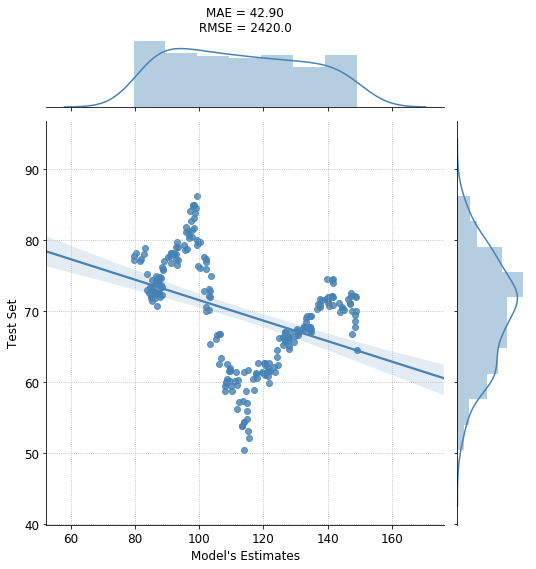

In [125]:
df_rmse = pd.DataFrame(ts_test.copy())
df_rmse['yhat'] = pred_2.values

g = sns.jointplot(x='yhat', y='y', data = df_rmse, kind="reg", color="steelblue")
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
ax = g.fig.axes[1]
ax.set_title("MAE = {:4.2f}\nRMSE = {:4.1f}".format(MAE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values), RMSE(df_rmse.loc[:,'y'].values, df_rmse.loc[:,'yhat'].values)), fontsize=12)
ax = g.fig.axes[0]
ax.set_xlabel("Model's Estimates", fontsize=12)
ax.set_ylabel("Test Set", fontsize=12)
ax.grid(ls=':')